# Chest X-Ray (Pneumonia): Analyzing the Datase

This Notebook analyzes the X-Ray dataset \
For further information on this work see the article https://arxiv.org/abs/1711.05225 which is one of the first articles on this subject \
Check Kaggle competition as well : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

### Dataset Information

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

from matplotlib.pyplot import imshow
pd.options.display.max_colwidth = 100

import random
import os
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2
from PIL import Image

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
# folder structure 
#Notebook
#    !------ chest_xray_data
#                  !-------------train
#                  !-------------test
#                  !-------------val
#
main_path = "./chest_xray_data/"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

In [4]:
# creation of 3 datasets train, test, val

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), 
                        columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), 
                       columns = ['class'])
df_test['image'] = [x for x in test_list]

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_val= pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), 
                     columns = ['class'])
df_val['image'] = [x for x in val_list]

In [5]:
df_train

,class,image
0,Normal,./chest_xray_data/train/NORMAL/IM-0713-0001.jpeg
1,Normal,./chest_xray_data/train/NORMAL/NORMAL2-IM-0636-0001.jpeg
2,Normal,./chest_xray_data/train/NORMAL/IM-0365-0001.jpeg
3,Normal,./chest_xray_data/train/NORMAL/NORMAL2-IM-1285-0001.jpeg
4,Normal,./chest_xray_data/train/NORMAL/IM-0703-0001.jpeg
...,...,...
5211,Pneumonia,./chest_xray_data/train/PNEUMONIA/person1430_virus_2444.jpeg
5212,Pneumonia,./chest_xray_data/train/PNEUMONIA/person1451_virus_2479.jpeg
5213,Pneumonia,./chest_xray_data/train/PNEUMONIA/person316_virus_641.jpeg
5214,Pneumonia,./chest_xray_data/train/PNEUMONIA/person281_bacteria_1327.jpeg


In [6]:
df_test

,class,image
0,Normal,./chest_xray_data/test/NORMAL/NORMAL2-IM-0366-0001.jpeg
1,Normal,./chest_xray_data/test/NORMAL/IM-0039-0001.jpeg
2,Normal,./chest_xray_data/test/NORMAL/IM-0035-0001.jpeg
3,Normal,./chest_xray_data/test/NORMAL/IM-0105-0001.jpeg
4,Normal,./chest_xray_data/test/NORMAL/IM-0063-0001.jpeg
...,...,...
619,Pneumonia,./chest_xray_data/test/PNEUMONIA/person155_bacteria_730.jpeg
620,Pneumonia,./chest_xray_data/test/PNEUMONIA/person81_bacteria_396.jpeg
621,Pneumonia,./chest_xray_data/test/PNEUMONIA/person78_virus_140.jpeg
622,Pneumonia,./chest_xray_data/test/PNEUMONIA/person1635_virus_2831.jpeg


### Data Exploration

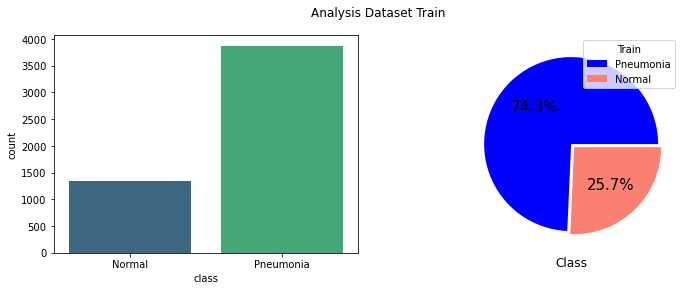

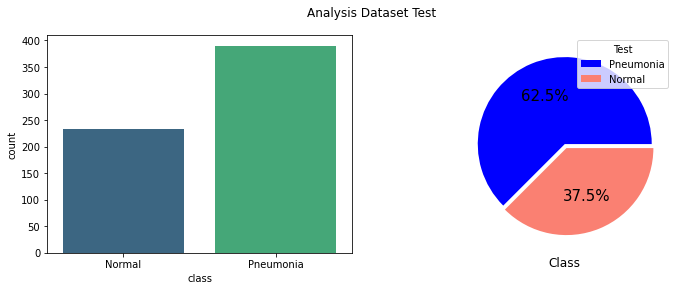

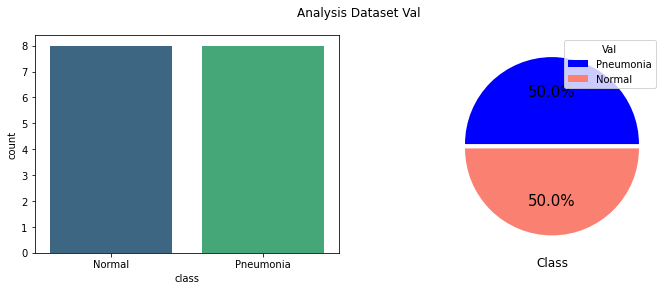

In [7]:
# Visualizes dataframe structure with 2 plots

def visualizing_data(df, Name_title):

   fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    
   fig.suptitle('Analysis Dataset '+ Name_title)
   sns.countplot(x='class', data=df, palette="viridis", ax = axes[0])
   axes[0] = plt.xlabel("Class", fontsize= 12)


   axes[1] = plt.pie(df['class'].value_counts(), labels = ['',''],colors = ['blue','salmon'], 
                      explode = [0,0.05], textprops = {"fontsize":15},autopct='%1.1f%%')
#   axes[0].set_suptitle('pollo')
   axes[1]= plt.legend(labels=['Pneumonia', 'Normal'])
   axes[1].set_title(Name_title)
   plt.show()
   return

visualizing_data(df_train,'Train') 
visualizing_data(df_test,'Test') 
visualizing_data(df_val,'Val')    

### Internal structure of the raw data

In [8]:
sample_image = cv2.imread(df_train.iloc[0]['image'])

print('Raw image structure :', sample_image.shape)


Raw image structure : (1329, 1636, 3)


In [9]:
df_train['matrix'] = df_train['image'].apply(lambda x: np.asarray(Image.open(x)))
df_train['shapes'] = df_train['matrix'].apply(lambda x: x.shape)
df_train['shapes']

0        (1329, 1636)
1        (1051, 1376)
2        (1229, 1600)
3        (2169, 1962)
4        (1052, 1426)
            ...      
5211      (864, 1200)
5212       (560, 880)
5213    (240, 496, 3)
5214       (648, 904)
5215      (798, 1122)
Name: shapes, Length: 5216, dtype: object

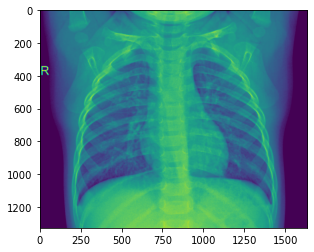

In [10]:
sample_image = df_train.iloc[0]['matrix']
imshow(np.asarray(sample_image))

In [11]:
df_train['matrix'] = df_train['image'].apply(lambda x: cv2.imread(x))
df_train['shapes'] = df_train['matrix'].apply(lambda x: x.shape)

In [12]:
df_train['shapes']

0       (1329, 1636, 3)
1       (1051, 1376, 3)
2       (1229, 1600, 3)
3       (2169, 1962, 3)
4       (1052, 1426, 3)
             ...       
5211     (864, 1200, 3)
5212      (560, 880, 3)
5213      (240, 496, 3)
5214      (648, 904, 3)
5215     (798, 1122, 3)
Name: shapes, Length: 5216, dtype: object

In [13]:
df_train['matrix']

0       [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 1,...
1       [[[49, 49, 49], [51, 51, 51], [49, 49, 49], [49, 49, 49], [50, 50, 50], [51, 51, 51], [55, 55, 5...
2       [[[41, 41, 41], [41, 41, 41], [40, 40, 40], [39, 39, 39], [38, 38, 38], [38, 38, 38], [37, 37, 3...
3       [[[0, 0, 0], [103, 103, 103], [102, 102, 102], [101, 101, 101], [99, 99, 99], [99, 99, 99], [100...
4       [[[47, 47, 47], [50, 50, 50], [49, 49, 49], [46, 46, 46], [48, 48, 48], [47, 47, 47], [55, 55, 5...
                                                       ...                                                 
5211    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0,...
5212    [[[121, 121, 121], [127, 127, 127], [131, 131, 131], [124, 124, 124], [107, 107, 107], [96, 96, ...
5213    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0,...
5214    [[[47, 47, 47], [47,

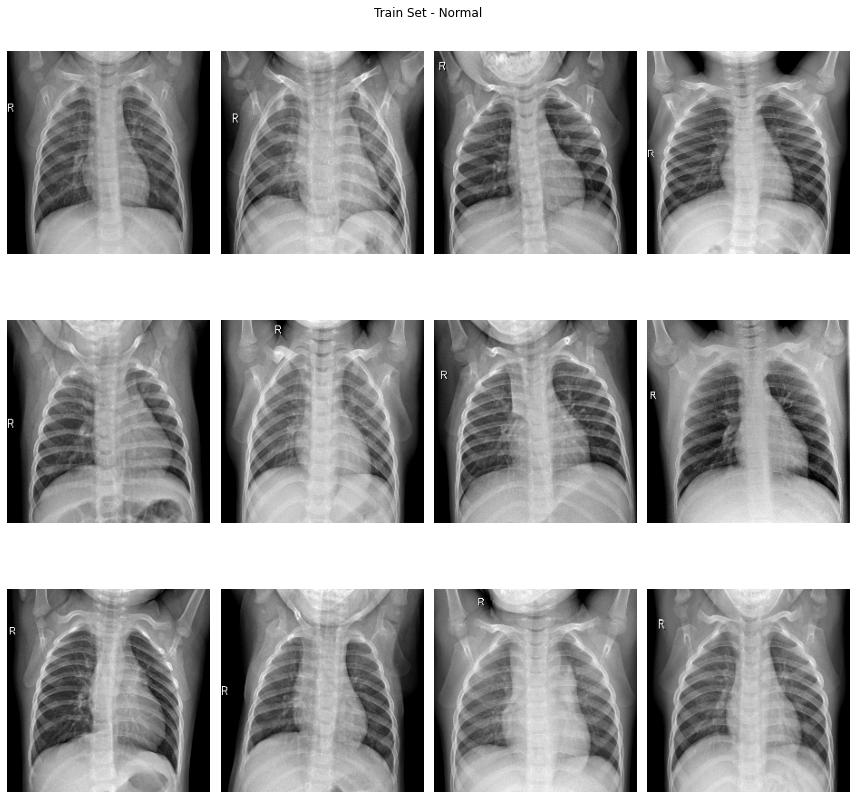

In [14]:
#Train Set - Normal

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Train Set - Normal')

plt.show()

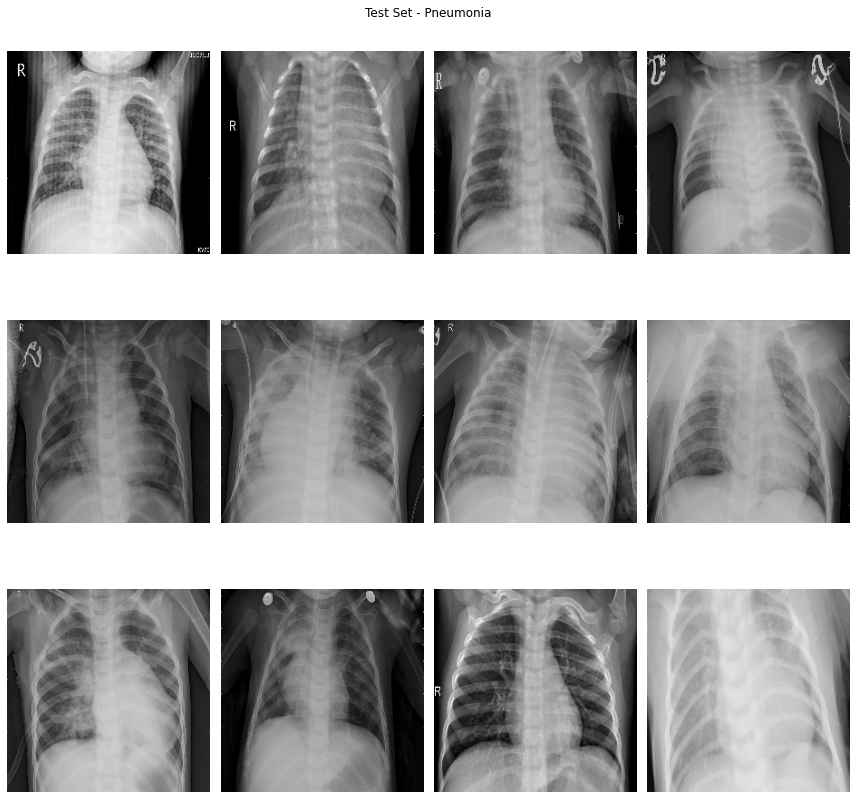

In [15]:
# Train Set - Pneumonia

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Test Set - Pneumonia')

plt.show()

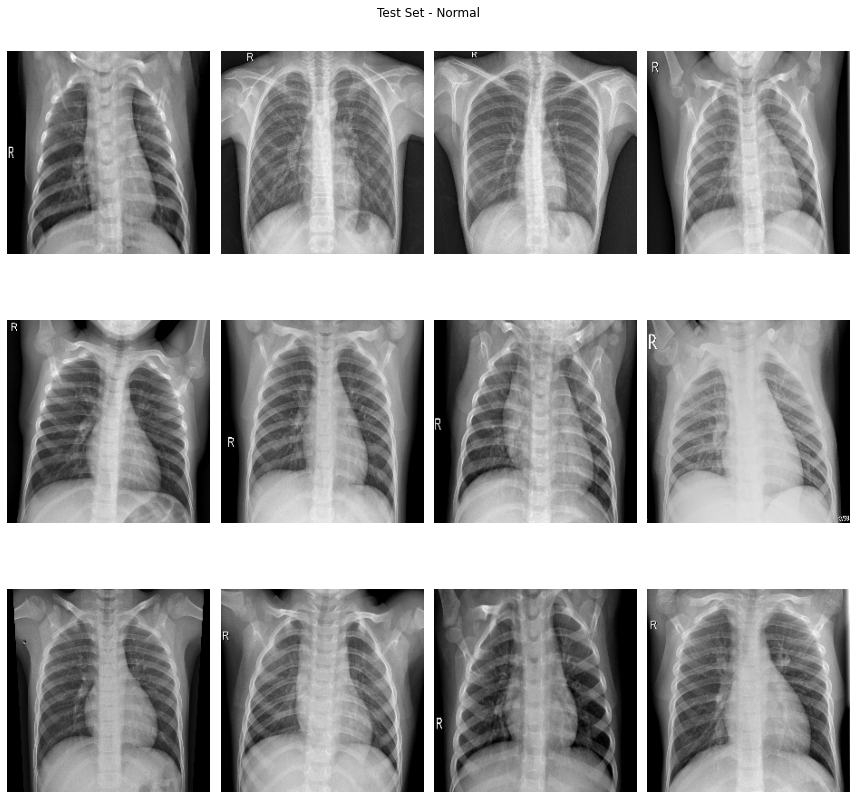

In [16]:
# test set normal
plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Test Set - Normal')

plt.show()

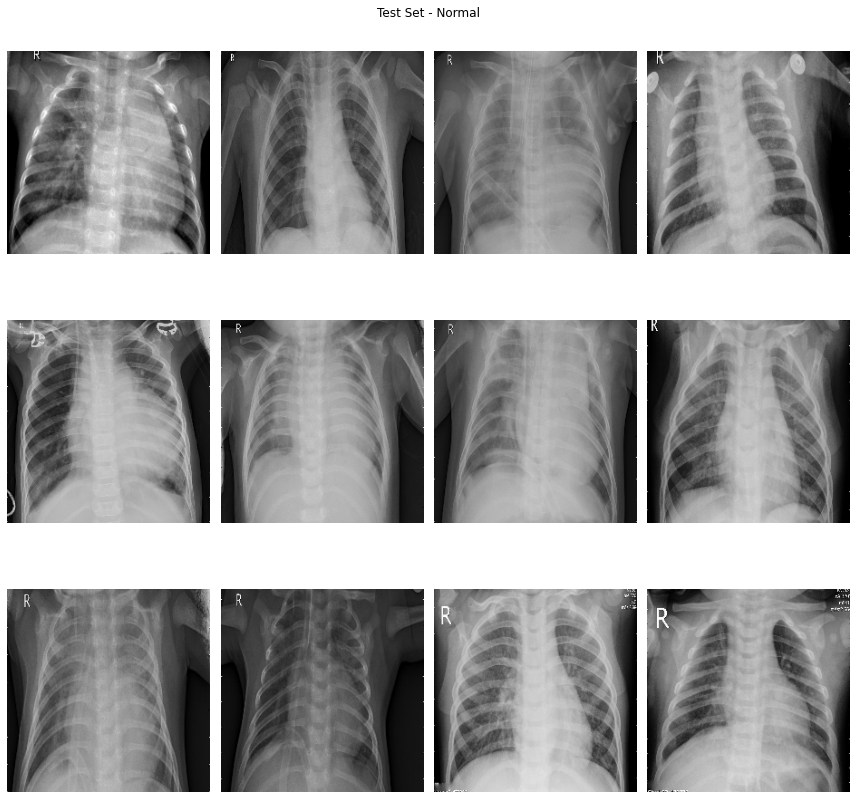

In [17]:
# Test Set - Pneumonia

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.suptitle('Test Set - Normal')

plt.show()